In [1]:
import os
import cv2
import numpy as np

IMG_WIDTH, IMG_HEIGHT = 128, 128  # Set the desired image dimensions

def load_images(directory):
    images = []
    labels = []
    for category in os.listdir(directory):
        category_path = os.path.join(directory, category)

        # Skip the unclassified folder
        if category == 'unclassified':
            continue

        # Iterate over each label folder within the category
        for label in os.listdir(category_path):
            label_path = os.path.join(category_path, label)
            
            for file in os.listdir(label_path):
                img_path = os.path.join(label_path, file)
                
                # Ensure only image files are processed
                if not file.lower().endswith(('.jpg', '.jpeg', '.png')):
                    print(f"Skipping non-image file: {file}")
                    continue
                
                img = cv2.imread(img_path)
                
                # Check if the image was read correctly
                if img is None:
                    print(f"Warning: Unable to read image at path: {img_path}")
                    continue
                
                img = cv2.resize(img, (IMG_WIDTH, IMG_HEIGHT))
                images.append(img)
                labels.append(label)  # Using the specific label (e.g., "cat") as the label
    return np.array(images), np.array(labels)

# Path to your dataset
data_path = r'C:\Users\KIIT0001\Desktop\ml projects\unzipped_origami'
images, labels = load_images(data_path)

# Normalize images
images = images / 255.0

Skipping non-image file: camel-18-min.webp
Skipping non-image file: cd2741bc7f6b48558d807f352bbd6626.webp
Skipping non-image file: duplicate_0_il_570xN.1751489813_n5e4.webp
Skipping non-image file: s-l1200.webp
Skipping non-image file: grid_0_640_N.webp
Skipping non-image file: HummingBird-Featured-Image.webp
Skipping non-image file: hummingbird.webp
Skipping non-image file: origami-stegosaurus (1).webp
Skipping non-image file: origami-stegosaurus.webp
Skipping non-image file: origami-tuojiangosaurus.webp
Skipping non-image file: stegosaurus (1).webp
Skipping non-image file: Stegosaurus.webp
Skipping non-image file: vrklSe7_d.webp
Skipping non-image file: 6426a903d0f1d5d806f02703e4179f4049a7ab21_2000x2000.webp
Skipping non-image file: scorpion-snake-min.webp
Skipping non-image file: Scorpions.webp
Skipping non-image file: Downloads - Shortcut.lnk


In [3]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)  # Convert labels to numeric
num_classes = len(label_encoder.classes_)        # Count unique classes

In [5]:
import pickle
with open('label_encoder.pkl', 'wb') as f:
    pickle.dump(label_encoder, f)

In [3]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(images, encoded_labels, test_size=0.2, random_state=37)

In [4]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Fit generator to the training data
datagen.fit(X_train)

In [5]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_generator = datagen.flow(
    X_train, y_train,
    batch_size=16,
    shuffle=True
)

# Wrap generator with tf.data.Dataset.from_generator
def train_gen():
    for x, y in train_generator:
        yield x, y

# Define output types and shapes explicitly
output_types = (tf.float32, tf.int64)
output_shapes = (
    tf.TensorShape([None, IMG_HEIGHT, IMG_WIDTH, 3]),  # Batch of images
    tf.TensorShape([None])                              # Batch of labels
)

train_dataset = tf.data.Dataset.from_generator(
    train_gen,
    output_types=output_types,
    output_shapes=output_shapes
)

Instructions for updating:
Use output_signature instead
Instructions for updating:
Use output_signature instead


In [6]:
train_dataset = train_dataset.prefetch(tf.data.AUTOTUNE)

In [7]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Define the base model
#base_model = MobileNetV2(input_shape=(IMG_WIDTH, IMG_HEIGHT, 3), include_top=False, weights='imagenet')
base_model = MobileNetV2(input_shape=(IMG_WIDTH, IMG_HEIGHT, 3),
                           include_top=False,
                           weights='imagenet')
base_model.trainable = True  # Unfreeze the base model layers

# Add custom layers on top of the base model
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu', kernel_regularizer=l2(0.01))(x)
x= Dropout(0.5)(x)
output_layer = Dense(num_classes, activation='softmax')(x)

# Create the full model
model = Model(inputs=base_model.input, outputs=output_layer)

# Compile the model
model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Define callbacks
checkpoint = ModelCheckpoint(
    filepath="CraftCortex.keras",
    monitor='val_accuracy',  # Monitor validation accuracy
    save_best_only=True,
    mode='max',
    verbose=1
)

lr_scheduler = ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.5,
    patience=5,
    min_lr=1e-6,
    verbose=1
)

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights = dict(enumerate(class_weights))

# Train the model
history = model.fit(
    train_dataset,
    steps_per_epoch=228,
    epochs=100,
    validation_data=(X_val, y_val),
    callbacks=[checkpoint, lr_scheduler, early_stopping],
    class_weight=class_weights
)

Epoch 1/100
228/228 ━━━━━━━━━━━━━━━━━━━━ 0s 508ms/step - accuracy: 0.0237 - loss: 6.8763
Epoch 1: val_accuracy improved from -inf to 0.02732, saving model to CraftCortex.keras
228/228 ━━━━━━━━━━━━━━━━━━━━ 193s 554ms/step - accuracy: 0.0238 - loss: 6.8762 - val_accuracy: 0.0273 - val_loss: 6.5761 - learning_rate: 1.0000e-04
Epoch 2/100
228/228 ━━━━━━━━━━━━━━━━━━━━ 0s 512ms/step - accuracy: 0.0563 - loss: 6.3931
Epoch 2: val_accuracy improved from 0.02732 to 0.09071, saving model to CraftCortex.keras
228/228 ━━━━━━━━━━━━━━━━━━━━ 123s 541ms/step - accuracy: 0.0563 - loss: 6.3928 - val_accuracy: 0.0907 - val_loss: 6.1652 - learning_rate: 1.0000e-04
Epoch 3/100
228/228 ━━━━━━━━━━━━━━━━━━━━ 0s 499ms/step - accuracy: 0.1118 - loss: 5.9016
Epoch 3: val_accuracy improved from 0.09071 to 0.18251, saving model to CraftCortex.keras
228/228 ━━━━━━━━━━━━━━━━━━━━ 120s 528ms/step - accuracy: 0.1119 - loss: 5.9012 - val_accuracy: 0.1825 - val_loss: 5.5960 - learning_rate: 1.0000e-04
Epoch 4/100
228/228

In [21]:
test_loss, test_accuracy = model.evaluate(X_val, y_val)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

29/29 ━━━━━━━━━━━━━━━━━━━━ 6s 193ms/step - accuracy: 0.7502 - loss: 1.3005
Test Accuracy: 76.17%


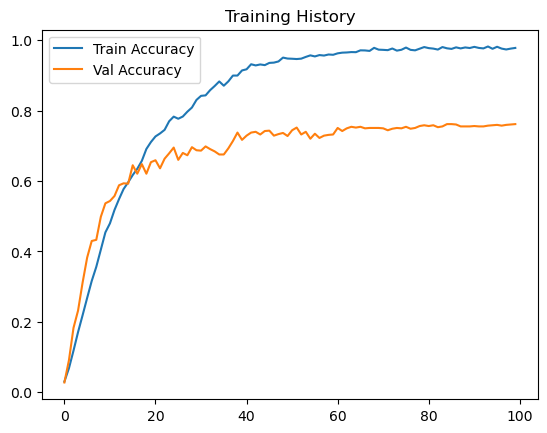

In [23]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.legend()
plt.title('Training History')
plt.show()

In [25]:
model.save("CraftCortex.h5", include_optimizer=True)

In [27]:
model.save("CraftCortex.keras", include_optimizer=True)